# Estimate message count

Below code relatively quickly calculates the number of messages a naive implementation of a distributed binary tree would use to sum up $n$ summands over $m$ ranks.

```python
from collections import deque

def parent(i):
    return i & (i - 1)

def subtree_size(i):
    largest_child_idx = i | (i - 1)
    return largest_child_idx + 1 - i

"""
Determine the number of messages in O(n) where n is the number of messages.

Arguments:
  - ns must be a list with the number of values assigned to each rank.
    Each rank must be assigned at least 1 number!
"""
def message_count(ns):
    assert(min(ns) > 0)

    # No communication needed if there is only one rank
    if len(ns) <= 1:
        return 0

    # calculate the startIndices for each rank, add a guard element at the end.
    startIndices = deque([sum(ns[:i]) for i in range(len(ns)+1)])
    guard = startIndices[-1]
    
    # We can omit the first rank, since it does not need to send its results anywhere
    startIndices.popleft()
    
    idx = startIndices[0]
    message_count = 0
    
    while idx < guard:
        # Fetch the limits for the current rank
        begin = startIndices[0]
        end = startIndices[1]
        
        # Through the subtree_iteration we can assume that each index update yields
        # another rank-intersecting index.
        assert(parent(idx) < begin)
        message_count += 1
        
        # Update the index. If the whole subtree is local we can skip over it completely,
        # since its result will be sent in only one message. If the subtree is split over
        # one or more ranks, we update the index to the start index of the next rank.
        idx = min(idx + subtree_size(idx), end)
        
        if idx == end:
            startIndices.popleft()
    
    return message_count
    
    
# Calculate an ns array which sums n parts over m ranks.
def even_distribution(n, m):
    partsPerRank = int(n // m)
    remainder = int(n % m)
    
    return [partsPerRank + 1] * remainder + [partsPerRank] * (m - remainder)
```

For a tight feedback loop, above implementation is still not fast enough. An external C++ module located in the `./cpp/` folder is loaded to calculate message counts over hundreds of thousands dataset sizes quickly using OpenMP. The `message_count` function takes a list of different numbers of summands as first argument and a fixed number of ranks as second argument.

In [21]:
%%script bash
cd cpp
python3 setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.10
creating build/lib.linux-x86_64-3.10/RADTree
copying RADTree/__init__.py -> build/lib.linux-x86_64-3.10/RADTree
running build_ext
building 'radtree' extension
creating build/temp.linux-x86_64-3.10
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -march=x86-64 -mtune=generic -O3 -pipe -fno-plt -march=x86-64 -mtune=generic -O3 -pipe -fno-plt -march=x86-64 -mtune=generic -O3 -pipe -fno-plt -fPIC -I/usr/include/python3.10 -c tree.cpp -o build/temp.linux-x86_64-3.10/tree.o -O3 -fopenmp
g++ -pthread -shared -Wl,-O1,--sort-common,--as-needed,-z,relro,-z,now -Wl,-O1,--sort-common,--as-needed,-z,relro,-z,now build/temp.linux-x86_64-3.10/tree.o -L/usr/lib -o build/lib.linux-x86_64-3.10/radtree.cpython-310-x86_64-linux-gnu.so -lgomp


In [23]:
# Import faster C++ implementation
import sys
from glob import glob
sys.path.append(glob("cpp/build/lib*/")[0])

from radtree import message_count, message_count_remainder_at_end

In [9]:
message_count([9], 4)

[6]

## Number of messages for a fixed cluster_size.

In [10]:
import numpy as np

m = 154 # number of ranks
X = np.arange(m, 100_000, dtype=np.uint)
Y = np.array(message_count(list(X), m))

<IPython.core.display.Javascript object>


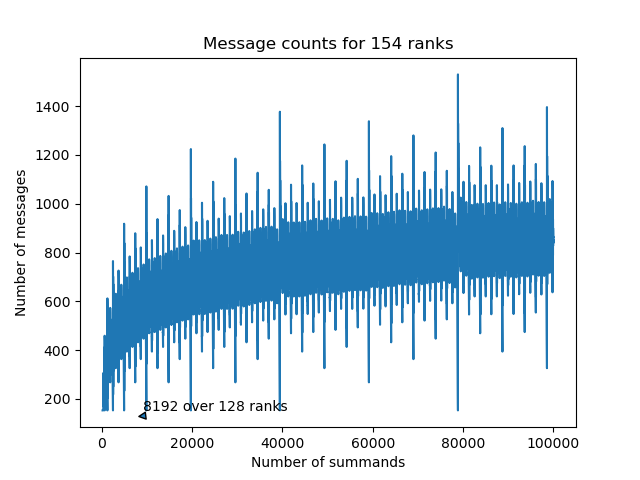

In [11]:

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

%matplotlib notebook

formatter1 = EngFormatter(places=0)

f = plt.figure()
ax = f.subplots(1)
plt.title(f"Message counts for {m} ranks")
ax.set_xlabel("Number of summands")
ax.set_ylabel("Number of messages")
#ax.xaxis.set_major_formatter(formatter1)

plt.annotate("8192 over 128 ranks", xy=(8192.0, 128), xytext=(9200.0, 150.0),
    arrowprops=dict(
        arrowstyle="simple",
))
plt.plot(X, Y)

plt.show()

## Fitting a curve

Next, we will try to approximate the average number of messages with a fitted curve.

<IPython.core.display.Javascript object>


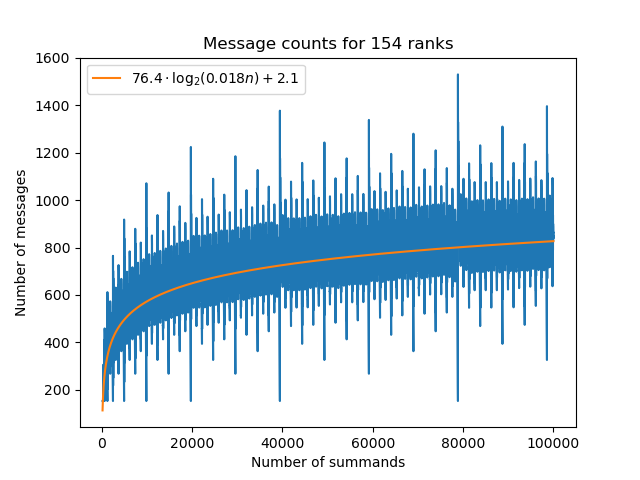

In [12]:
from scipy.optimize import curve_fit

# Try to fit a curve onto the data.
def function(x, a, b, c):
    return a * np.log2(b * x) + c

popt, pcov = curve_fit(function, X, Y, bounds=([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf]))

f = plt.figure()
ax = f.subplots(1)
plt.title(f"Message counts for {m} ranks")
ax.set_xlabel("Number of summands")
ax.set_ylabel("Number of messages")

ax.plot(X, Y)
ax.plot(X, function(X, *popt), label=f"${popt[0]:.3}\cdot\log_2({popt[1]:.2}n) {popt[2]:+.2} $")

ax.legend(loc='upper left')

plt.show()
plt.savefig("message_count_log.svg")

In [13]:
print(message_count([8,9, 16,17, 32, 33, 64, 65, 128,129, 256, 257], 4))


test_m = 99
counts = np.array(message_count([2**i * test_m + 1 for i in range(1, 10)], test_m), dtype=np.float64)
counts /= test_m - 1
print(counts)

[3, 6, 3, 9, 3, 12, 3, 15, 3, 18, 3, 21]
[ 2.  3.  4.  5.  6.  7.  8.  9. 10.]


In above graph, one can easily observe that the message count spikes when $n - 1$ is a power of two times the cluster size $m$:

$$N_{\textrm{worstcase}}(m) = \{2^im+1\; \big|\; i \in \mathbb{N} \}$$

The corresponding number of messages for elements of $N_{\textrm{worstcase}}(m)$ for each $i$ is $(i + 1) (m - 1)$. A worst-case approximation of the number of messages is given by the equation

$$M_{\textrm{worstcase}}(n) = (m - 1) (\log_2 \Big( \frac{n - 1}{m} \Big) + 1)$$

<IPython.core.display.Javascript object>


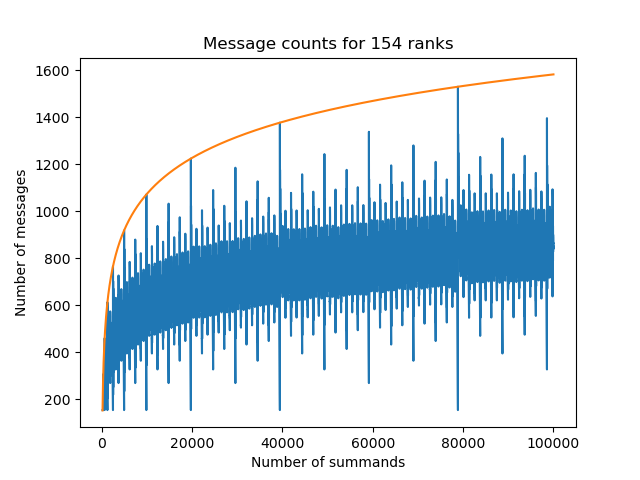

In [14]:
f = plt.figure()
ax = f.subplots(1)
plt.title(f"Message counts for {m} ranks")
ax.set_xlabel("Number of summands")
ax.set_ylabel("Number of messages")

ax.plot(X, Y)
ax.plot(X, (m - 1) * (np.log2((X - 1) / m) + 1))
plt.show()

<IPython.core.display.Javascript object>


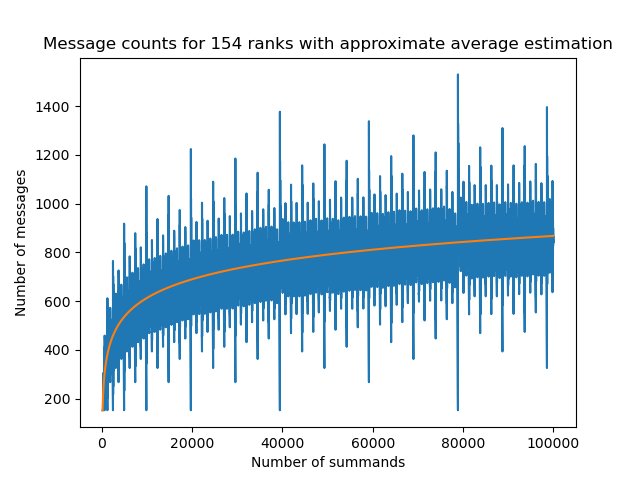

In [16]:
f = plt.figure()
ax = f.subplots(1)
plt.title(f"Message counts for {m} ranks with approximate average estimation")
ax.set_xlabel("Number of summands")
ax.set_ylabel("Number of messages")

ax.plot(X, Y)

worstcase = (m - 1) * (np.log2((X - 1) / m) + 1)
ax.plot(X, ((worstcase - (m - 1)) * 0.5) + (m - 1) )
plt.show()

<IPython.core.display.Javascript object>


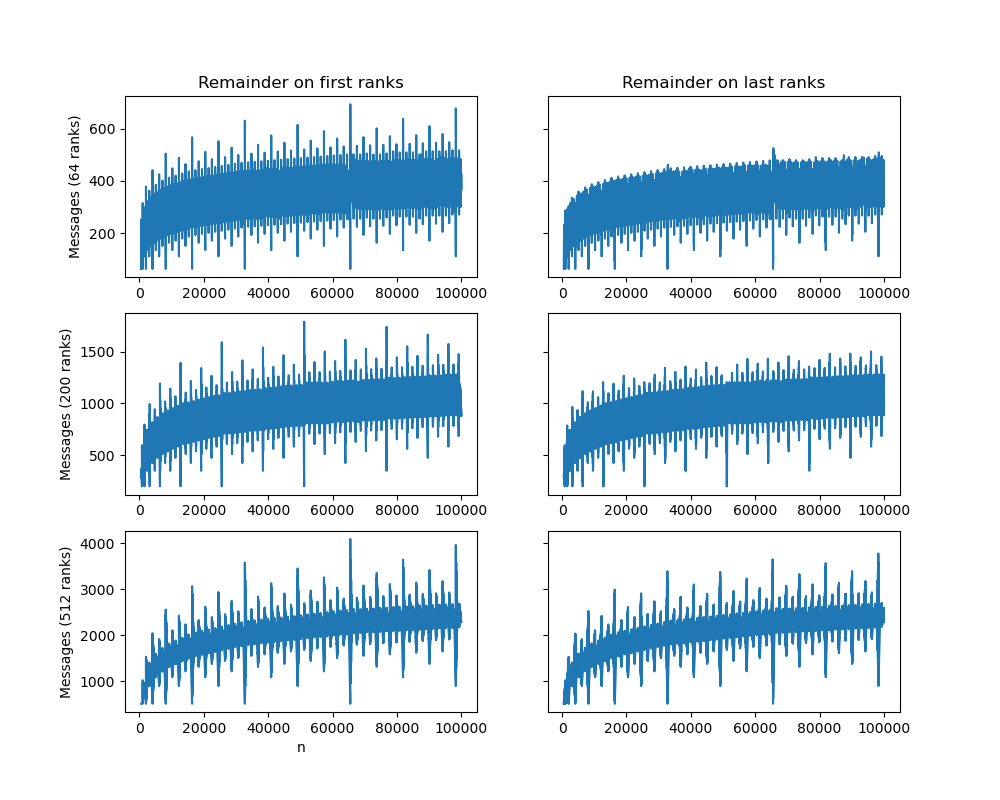

In [37]:

ms = [64, 200, 512]
X = np.arange(m, 100_000, dtype=np.uint)
Y = np.array(message_count(list(X), m))

f, ax = plt.subplots(nrows=len(ms), ncols=2, sharex='row', sharey='row', figsize=(10, 8))

ax[0][0].set_title("Remainder on first ranks")
ax[0][1].set_title("Remainder on last ranks")
ax[-1][0].set_xlabel("n")
for m, row in zip(ms, ax):
    ax1, ax2 = row
    
    ax1.set_ylabel(f"Messages ({m} ranks)")
    ax1.plot(X, np.array(message_count(list(X), m)))
    ax2.plot(X, np.array(message_count_remainder_at_end(list(X), m)))
    
plt.savefig("remainder_first_vs_last.svg")
